# Introducción:

El objetivo es `predecir el riesgo crediticio` de los individuos en función de su información financiera y demográfica utilizando el conjunto de datos de kaggle (ver biblio). 

La predicción del riesgo crediticio es crucial para las instituciones financieras a fin de tomar decisiones informadas sobre los préstamos, con el objetivo de minimizar el riesgo de incumplimiento y optimizar el proceso de aprobación.

El conjunto de datos contiene información sobre 1000 individuos, incluyendo:
 -  Edad, 
 -  Género, 
 -  Tipo de trabajo, 
-   Estado de vivienda, 
-   Ahorros, 
-   Cuentas corrientes,
-   Monto del crédito en DM (Marcos Alemanes), 
-   Duración del préstamo,
-   Propósito del mismo. 


La tarea consiste en analizar estas características y construir un modelo de ML usando `Random forest classifier` que pueda predecir si una persona tiene alta o baja probabilidad de ser un prestatario de alto riesgo.

# 1. Importar módulos 🤖

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# 2. Cargar csv y analizar datos generales 🆙

Verificamos la info del dataset y visualizamos las primeras lineas 

In [41]:
# Cargamos el dataset
df = pd.read_csv('./credit_data.csv')

#dropear el index
df = df.iloc[:, 1:]  # Conserva todas las columnas excepto la primera (posición 0)

# ver la info general
df.info()
# Ejemplo con las primeras lineas
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
dtypes: int64(4), object(5)
memory usage: 70.4+ KB


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


# 3. Pre-procesamiento de los datos 🏭

-   Pasar de Marcos alemanes a MXN   
-   Necesitamos manejar los valores faltantes y codificar las variables categóricas en formatos numéricos.

In [42]:
# Manejar los NA con un placeholder
df = df.copy() 

#Conversion de Marcos alemanes a MXN: tipo de cambio 10.88 al 25/Nov/2024
def dm_a_mxn(df, nombre_columna):
    # Convertir la columna a numérica, forzando errores a NaN
    df[nombre_columna] = pd.to_numeric(df[nombre_columna], errors='coerce')
    # Multiplicar solo los valores numéricos
    df[nombre_columna] = df[nombre_columna] * 10.88
    return df

df = dm_a_mxn(df,'Credit amount')           #Monto del crédito


In [43]:
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

"""
Utiliza un bucle para procesar varias columnas categóricas: Sex, Housing, Saving accounts, Checking account, y Purpose.
Usa LabelEncoder para transformar estas categorías en valores numéricos:
Ejemplo: "male" -> 1, "female" -> 0.

Guarda los objetos LabelEncoder en un diccionario (label_encoders).
"""

label_encoders = {}
for column in ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

print(label_encoders)
df.head()


{'Sex': LabelEncoder(), 'Housing': LabelEncoder(), 'Saving accounts': LabelEncoder(), 'Checking account': LabelEncoder(), 'Purpose': LabelEncoder()}


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,1,2,1,4,0,12718.72,6,5
1,22,0,2,1,0,1,64746.88,48,5
2,49,1,1,1,0,3,22804.48,12,3
3,45,1,2,0,0,0,85756.16,42,4
4,53,1,2,0,0,0,52985.60,24,1


# 4. Exploratory Data Analysis (EDA) 🤯

Analisis de las features para saber su relación con el target y su distribución

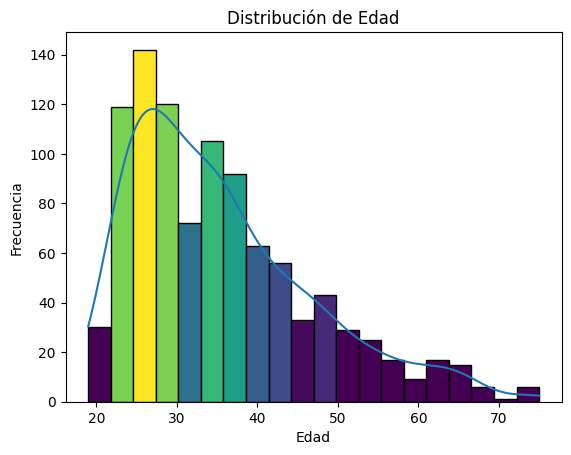

In [44]:
# Convertir los datos infinitos a NaNs
df = df.replace([np.inf, -np.inf], np.nan)

# Crear el histograma con Seaborn
hist = sns.histplot(df['Age'], kde=True, bins=20, edgecolor='black')

# Agregar gradiente a las barras
norm = plt.Normalize(hist.patches[0].get_height(), max(p.get_height() for p in hist.patches))
for patch in hist.patches:
    color = plt.cm.viridis(norm(patch.get_height()))  # Usar el colormap 'viridis'
    patch.set_facecolor(color)

# Configurar el título y mostrar el gráfico
plt.title('Distribución de Edad')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.show()


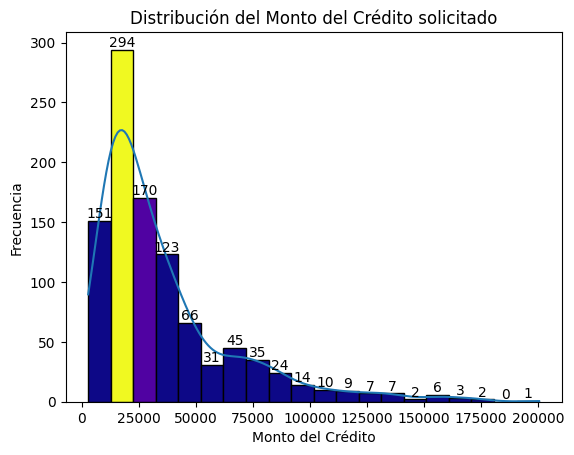

In [45]:
#Crear el histograma con Seaborn
hist2 = sns.histplot(df['Credit amount'], kde=True, bins=20, edgecolor='black')

# Agregar gradiente a las barras
norm = plt.Normalize(hist2.patches[0].get_height(), max(p.get_height() for p in hist2.patches))
for patch in hist2.patches:
    color = plt.cm.plasma(norm(patch.get_height()))  # Usar el colormap 'plasma'
    patch.set_facecolor(color)
    
    # Agregar texto (valor de frecuencia) sobre las barras
    height = patch.get_height()
    width = patch.get_width()
    x = patch.get_x() + width / 2  # Centrado en la barra
    y = height
    
    # Colocar el valor sobre la barra con un desplazamiento en y para que no se sobreponga
    plt.text(x, y, f'{int(height)}', ha='center', va='bottom', fontsize=10)

# Configurar el título y mostrar el gráfico
plt.title('Distribución del Monto del Crédito solicitado')
plt.xlabel('Monto del Crédito')
plt.ylabel('Frecuencia')
plt.show()


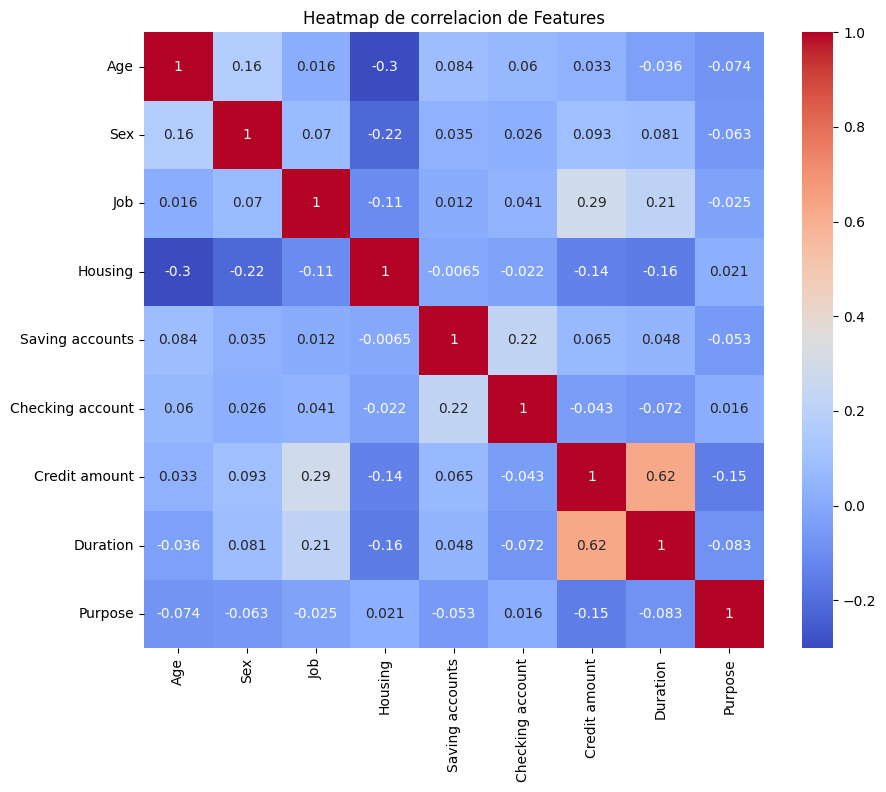

In [46]:
# Heatmap de correlacion
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap de correlacion de Features')
plt.show()

# 5. Separar entre train set y test set 🚂 / 🧾
Dividimos los datos en características (X) y objetivo (y), luego en conjuntos de entrenamiento y pruebas.

In [47]:
# Definir features y target
X = df.drop(columns=['Credit amount'])  # Tomamos Credit amount como variable target

# Clasificacion binaria (credito solicitado Bajo / Alto), si > a la media
y = df['Credit amount'] > df['Credit amount'].median()

In [48]:
# Separar entre en trainning set y el testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

¿Es necesaria la estandarización para Random Forest?
**No, estrictamente no es necesario**

Sin embargo:

Si las características tienen rangos extremadamente dispares (por ejemplo, edad de 20-70 y montos de crédito de 25,000-200,000), estandarizar ayuda a que el modelo aprenda de manera más uniforme durante la selección de atributos.

# 6. Fase de entrenamiento
Se usará un modelo clasificador tipo Random forest

# 🦾 Etapa de entrenamiento 🦾


In [49]:
model = RandomForestClassifier(n_estimators=100, random_state=69420)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=69420)

# 🏆 Etapa de Prediccion 🏆

In [50]:
print(X_test[0])

[-1.02204185 -1.46736265  0.09581896 -0.12451365 -0.70905715 -1.27200268
 -0.27354362  1.05641012]


In [51]:
# Predicciones en el set de testeo
y_pred = model.predict(X_test)

# 7. 📝Evaluamos el modelo:
Evaluamos el rendimiento del modelo mendiate:
1. La precisión, 
2. La matriz de confusión
3. El informe de clasificación.


In [52]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("------------------------------")

Accuracy: 0.75
------------------------------


### Explicación:

- **Exactitud (Accuracy):**  
  El modelo alcanzó una exactitud del 75%, lo que significa que predijo correctamente el estado de riesgo crediticio en el 75% de las muestras de prueba.

In [53]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de confusión:")
print(conf_matrix)

Matriz de confusión:
[[120  35]
 [ 39 106]]



- **Matriz de confusión:**  
  La matriz de confusión muestra cuántas instancias reales de cada clase fueron clasificadas correcta o incorrectamente.  
  - **Verdaderos Negativos (120):** El modelo identificó correctamente a 120 personas de bajo riesgo.  
  - **Falsos Positivos (35):** El modelo clasificó incorrectamente a 35 personas de alto riesgo como de bajo riesgo.  
  - **Falsos Negativos (39):** El modelo clasificó incorrectamente a 39 personas de bajo riesgo como de alto riesgo.  
  - **Verdaderos Positivos (106):** El modelo identificó correctamente a 106 personas de alto riesgo.  


In [54]:
class_report = classification_report(y_test, y_pred)
print("------------------------------")
print("Reporte de clasificacion:")
print(class_report)

------------------------------
Reporte de clasificacion:
              precision    recall  f1-score   support

       False       0.75      0.77      0.76       155
        True       0.75      0.73      0.74       145

    accuracy                           0.75       300
   macro avg       0.75      0.75      0.75       300
weighted avg       0.75      0.75      0.75       300



- **Informe de clasificación:**  
  - **Precisión (Precision):** Mide la exactitud de las predicciones positivas.  
  - **Sensibilidad (Recall):** Mide la capacidad de identificar instancias positivas.  
  - **Puntaje F1 (F1-Score):** Media armónica de precisión y sensibilidad, útil para evaluar conjuntos de datos desbalanceados.  

### El modelo muestra un rendimiento equilibrado entre las dos clases, aunque aún hay margen de mejora.

# Conclusión:


-   El modelo alcanzó una exactitud del 75%, lo que indica un desempeño razonable en la predicción del riesgo crediticio.
-   La matriz de confusión y el informe de clasificación sugieren que, aunque el modelo tiene un buen desempeño general, todavía existen errores de clasificación, especialmente en los falsos positivos y falsos negativos.

# 2NDA PARTE-----------------------------   
##  Testing en produccion

>Pasamos a `.pkl` para serializar el modelo y usarlo como un archivo

In [55]:
import pickle
# Guardar el modelo con pickle
with open("random_forest_model.pkl", "wb") as file:
    pickle.dump(model, file)

print("Modelo guardado en 'random_forest_model.pkl'")

Modelo guardado en 'random_forest_model.pkl'


In [56]:
import joblib

# Guardar el modelo entrenado
joblib.dump(model, 'joblib_random_forest_model.pkl')


['joblib_random_forest_model.pkl']

![Pickle](https://media2.giphy.com/media/9zXWAIcr6jycE/giphy.gif)